# Critical Infrastructure

Notebook environment to migrate netcdf files to CF compliant zarr#

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from shapely import wkb

# Make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# Get root paths
home = pathlib.Path().home()
root = home.root

# Import custom functionality
from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy
from coclicodata.etl.cloud_utils import (
    load_google_credentials,
    dir_to_google_cloud,
    file_to_google_cloud,
)

# Define (local and) remote drives
coclico_data_dir_fast = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")
coclico_data_dir_full = p_drive.joinpath("11207608-coclico", "FULLTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
# os.environ["UDUNITS2_XML_PATH"] = str(
#     home.joinpath(  # change to the udunits2.xml file dir in your Python installation
#         r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
#     )
# )



C:\Users\kras\AppData\Local\Temp\ipykernel_11400\93513235.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [3]:
# Project paths & files (manual input)

# coastal LAU and NUTS coastal 
LAU_dataset_dir = coclico_data_dir_fast.joinpath("XX_LAU")
NUTS2_dataset_dir = coclico_data_dir_fast.joinpath("XX_NUTS")
LAU_ds_path = LAU_dataset_dir.joinpath("LAU_2020_NUTS_2021_01M_3035_CM.parquet")
NUTS2_ds_path = NUTS2_dataset_dir.joinpath("NUTS2_RG_01M_2021_3035_CM.parquet")

# CEED data
CEED_dataset_dir = coclico_data_dir_full.joinpath("WP5/data/nuts2_ceed")

<IPython.core.display.Javascript object>

### Creation of small test file

<Axes: >

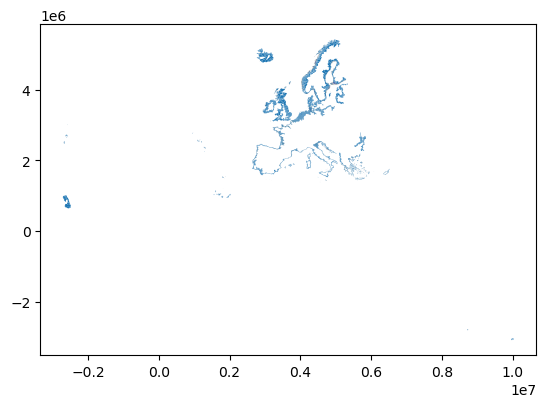

<IPython.core.display.Javascript object>

In [29]:
# load parquet data into geopandas geodataframes
LAU = pd.read_parquet(LAU_ds_path)
NUTS2 = pd.read_parquet(NUTS2_ds_path)

# fix geometries
LAU["geometry"] = LAU["geometry"].apply(lambda x: wkb.loads(x) if x else None)
NUTS2["geometry"] = NUTS2["geometry"].apply(lambda x: wkb.loads(x) if x else None)

# make geodataframe
LAU_gdf = gpd.GeoDataFrame(LAU, geometry="geometry")
NUTS2_gdf = gpd.GeoDataFrame(NUTS2, geometry="geometry")
LAU_gdf.plot()

In [30]:
# load CEED parquet data into geopandas dataframes
# NL33 (South Holland - largest)
# NL41 (Brabant - second largest)
# NL32 (North Holland - third largest)
# NL22 (Gelderland - fourth largest)
CEED = pd.read_parquet(CEED_dataset_dir.joinpath("NL32_CEED.parquet"))

# fix geometries
CEED["geometry"] = CEED["geometry"].apply(lambda x: wkb.loads(x) if x else None)

# make geodataframe
CEED_gdf = gpd.GeoDataFrame(CEED, geometry="geometry")

<IPython.core.display.Javascript object>

<Axes: >

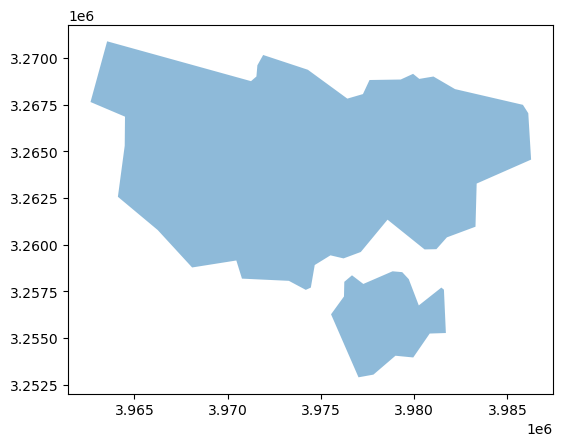

<IPython.core.display.Javascript object>

In [31]:
# cut up the NUTS2 CEED into smaller LAU CEED files
test_file = "NL_GM0363"

# select one LAU in the file
LAU_AMS = LAU_gdf[LAU_gdf["GISCO_ID"] == test_file]
LAU_AMS.plot(alpha=0.5)

In [32]:
# match geospatially the geodataframes (spatial join)
LAU_AMS_CEED = gpd.sjoin(CEED_gdf, LAU_AMS, how="inner", op="intersects")

c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<IPython.core.display.Javascript object>

In [35]:
# set the CRS
LAU_AMS_CEED = LAU_AMS_CEED.set_crs(epsg=3035)

# rename the FID column to avoid confusion
LAU_AMS_CEED = LAU_AMS_CEED.rename(columns={"FID": "LAU_FID"})

# drop all attributes except geometry
LAU_AMS_CEED = LAU_AMS_CEED[["geometry"]]

# reset multi-index to add type
LAU_AMS_CEED_plain = LAU_AMS_CEED.reset_index()
LAU_AMS_CEED["type"] = np.array(LAU_AMS_CEED_plain.level_0)

# multi-index names and counter info 
# CEEDtype = np.array(LAU_AMS_CEED.index.levels[0])
# for i in CEEDtype:
#     print(i, LAU_AMS_CEED.xs(i).shape)

<IPython.core.display.Javascript object>

In [36]:
# test
LAU_AMS_CEED_refact = LAU_AMS_CEED_plain.drop(columns=["level_1"], inplace=True) 
LAU_AMS_CEED_refact = LAU_AMS_CEED_plain.rename(columns={"level_0": "type"})
LAU_AMS_CEED_refact

,type,geometry
0,buildings,"POLYGON ((3980679.456 3255448.051, 3980679.457..."
1,buildings,"POLYGON ((3979429.675 3254097.242, 3979429.675..."
2,buildings,"POLYGON ((3979424.475 3254098.462, 3979424.475..."
3,buildings,"POLYGON ((3979419.210 3254099.694, 3979419.210..."
4,buildings,"POLYGON ((3979411.056 3254112.433, 3979411.056..."
...,...,...
193871,road,"LINESTRING (3965615.648 3268527.148, 3965600.1..."
193872,road,"LINESTRING (3964691.293 3268754.238, 3964753.0..."
193873,road,"LINESTRING (3965144.431 3268463.035, 3965136.5..."
193874,road,"LINESTRING (3964753.004 3268767.519, 3964767.8..."


<IPython.core.display.Javascript object>

In [39]:
# export to parquet
LAU_AMS_CEED_refact.to_parquet(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed").joinpath("%s_refact.parquet"%test_file))

<IPython.core.display.Javascript object>

In [40]:
# export to gkpg
LAU_AMS_CEED_refact.to_file(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed/gpkg").joinpath("%s_refact.gpkg"%test_file), driver="GPKG")

<IPython.core.display.Javascript object>

In [46]:
# put in bucket
GCS_PROTOCOL = "https://storage.googleapis.com"
GCS_PROJECT = "coclico-11207608-002"
BUCKET_NAME = "coclico-data-public"
BUCKET_PROJ = "coclico"
PROJ_NAME = "LAU_ceed"

# loading credentials
cred_data_dir = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")
load_google_credentials(
    google_token_fp=cred_data_dir.joinpath("google_credentials_new.json")
)

file_to_google_cloud(file_path=str(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed").joinpath("%s_refact.parquet"%test_file)),
                     gcs_project=GCS_PROJECT,
                     bucket_name=BUCKET_NAME,
                     bucket_proj=BUCKET_PROJ,
                     dir_name=PROJ_NAME,
                     file_name="%s_refact.parquet"%test_file)

file_to_google_cloud(file_path=str(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed/gpkg").joinpath("%s_refact.gpkg"%test_file)),
                     gcs_project=GCS_PROJECT,
                     bucket_name=BUCKET_NAME,
                     bucket_proj=BUCKET_PROJ,
                     dir_name=PROJ_NAME,
                     file_name="%s_refact.gpkg"%test_file)

Google Application Credentials load into environment.


<IPython.core.display.Javascript object>